This notebook will generate population parameters using the Ricker model, and I'm going to try and see if I can

1. Estimate the population parameters from this data
1. Fit the model with some other models and estimate parameters for them too


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import pymc3 as pm 
np.random.seed(9876)

In [2]:
%matplotlib inline

The Ricker model population is simulated with a constant observation error of $Normal(0,5)$ individuals

$N(t)=N(t-1)e^{r_{0}[1-\frac{N(t-1)}{K}]} + Normal(0,5)$



In [3]:
start_pop   =  5
r0 = 0.5
measure_error = 5
K = 200

timepoints = 50
steps = np.arange(timepoints)
N = np.zeros(steps.size)
N[0] = start_pop
for t in steps[1:]:
    value = -10
    while value <0: 
        value = N[t-1]*np.exp(r0*(1-N[t-1]/K)) + np.random.normal(0,measure_error)
        if value>0:
            N[t] = value

    

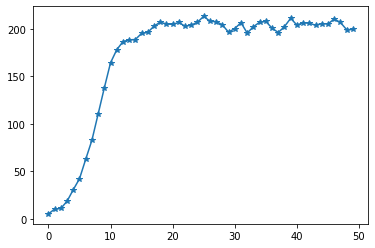

In [4]:
plt.figure()
plt.plot(steps,N,'-*');plt.show()

Now let's fit this model to the Ricker equation: $N(t)=N(t-1)e^{r_{0}[1-\frac{N(t-1)}{K}]}$

In [5]:
# generate the Nt and Nt-1
Nt = N[1:]; Ntm1 = N[:-1]

In the Ricker model there are two parameters to be estimated - $r_{0}$ and $K$. 

In [6]:
m0 = pm.Model()
with m0:
    r0 = pm.Uniform('r0',lower=0,upper=1)
    K = pm.Uniform('K', lower=1000, upper=3000)
    obs_std = pm.Uniform('obs_std', lower=2, upper=7)
    nt_mean =  pm.Deterministic('nt_mean', Ntm1*pm.math.exp(r0*(1-(Ntm1/K))))
    nt = pm.Normal('nt', mu=nt_mean, sigma=obs_std, observed=Nt)
    m0_trace = pm.sample()    
    post_check = pm.sample_posterior_predictive(samples=1000,trace=m0_trace,var_names=['nt_mean','nt','r0','K','obs_std'])

/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_std, K, r0]


/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


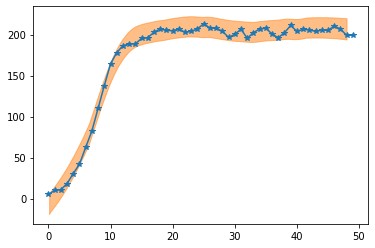

In [7]:
plt.figure()
a0 = plt.subplot(111)
#az.plot_hdi(steps[:-1],post_check['nt_mean'],hdi_prob=.93)
az.plot_hdi(steps[:-1],post_check['nt'],hdi_prob=.93)
a0.plot(steps,N,'-*');plt.show()


In [8]:
for each in ['r0','K','obs_std']:
    print(each,az.hdi(post_check[each],0.93))

r0 [1.27682696e-05 2.11592656e-02]
K [1001.30540782 2860.6125171 ]
obs_std [6.65864853 6.9992279 ]


Oddly enough, the values seem to be off the simulated values quite a bit!! Woah. How well can we estimate the parameters for a Logistic model?

In [9]:
m1 = pm.Model()
with m1:
    r0 = pm.Uniform('r0',lower=0,upper=1)
    K = pm.Uniform('K', lower=1000, upper=3000)
    obs_std = pm.Uniform('obs_std', lower=2, upper=7)
    nt_mean =  pm.Deterministic('nt_mean', Nt*(1+r0*(1-(Nt/K))))
    nt = pm.Normal('nt', mu=nt_mean, sigma=obs_std, observed=Nt)
    m1_trace = pm.sample()    
    post_check1 = pm.sample_posterior_predictive(samples=1000,trace=m0_trace,var_names=['nt','r0','K','obs_std'])

/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_std, K, r0]


/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


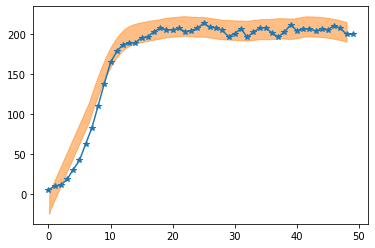

In [10]:
plt.figure()
a0 = plt.subplot(111)
#az.plot_hdi(steps[:-1],post_check['nt_mean'],hdi_prob=.93)
az.plot_hdi(steps[:-1],post_check1['nt'],hdi_prob=.93)
a0.plot(steps,N,'-*');plt.show()


In [11]:
m0_data = az.from_pymc3(m0_trace)
m1_data = az.from_pymc3(m1_trace)

/home/autumn/anaconda3/envs/statsre/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [12]:
m0_data.log_likelihood.sum().to_array().sum()

<xarray.DataArray ()>
array(-371749.69023173)

Let's also do the Hassell model:
$N_{t+1} = \frac{KN_{t}(r0+1)}{K+N_{t}r0}$